# SML project - SMS spam detection

### Olivier Pelgrin, François Mentec, Hugo Martin

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

import re # regex

In [2]:
#Import spam data and shaping it
smsList = pd.read_table("SMSSpamCollection.txt", header=None, names=['label', 'message'])

smsList["label"] = smsList["label"].map({"ham":0,"spam":1})

X = smsList.message
y = smsList.label

## Naive bayes

In [3]:
#Splitting dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
vect = CountVectorizer()

In [5]:
X_train_vect = vect.fit_transform(X_train)

In [6]:
X_test_vect = vect.transform(X_test)

In [7]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

y_prediction_class = nb.predict(X_test_vect)

metrics.accuracy_score(y_test, y_prediction_class)

0.98851399856424982

### With 10-fold cross validation :

In [8]:
def cross_val(model):
    kf = KFold(n_splits=10)
    
    res = []
    
    for train_i, test_i in kf.split(X, y):
        cv = CountVectorizer()

        train_set = cv.fit_transform([X[i] for i in train_i])
        train_class = [y[i] for i in train_i]

        test_set = cv.transform([X[i] for i in test_i])
        test_class = [y[i] for i in test_i]

        model.fit(train_set,train_class)
        pred = model.predict(test_set)
        
        r = metrics.accuracy_score(test_class, pred)
        print(r)
        res.append(r)
        
    return np.mean(res)

In [9]:
nb = MultinomialNB()

nb_score = cross_val(nb)

print("Naive Bayes : " + str(nb_score*100) + "% accuracy")

0.989247311828
0.978494623656
0.980251346499
0.991023339318
0.982046678636
0.992818671454
0.983842010772
0.989228007181
0.980251346499
0.992818671454
Naive Bayes : 98.600220073% accuracy


[[1203    4]
 [  12  174]]


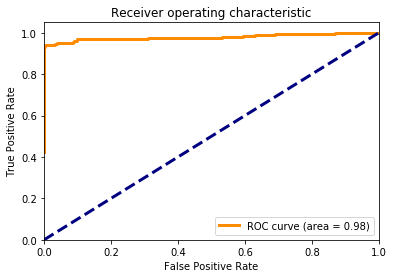

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

y_prediction_class = nb.predict(X_test_vect)

preds = nb.predict_proba(X_test_vect)[:,1]

cm = metrics.confusion_matrix(y_test, y_prediction_class)
print(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Naive Bayes models are known to have good results in text classification, so it is not surprising to have such a good score and ROC Curve, with an excellent 0.98 AUC score.  
The confusion matrix show us that there is few false positive and false negative.

## Backpropagation neural network
We're implementing the technique presented in this article :
[RUAN, Guangchen et TAN, Ying. A three-layer back-propagation neural network for spam detection using artificial immune concentration. Soft computing, 2010, vol. 14, no 2, p. 139-150.](https://link.springer.com/content/pdf/10.1007%2Fs00500-009-0440-2.pdf)

In [10]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [11]:
regex = re.compile('\w+')
words = {}
N = 0 # number of non-spam
S = 0 # number of spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""count words support in spam and non-spam sms
words['toto'][0] = number of non-spam sms containing the word 'toto'
words['toto'][1] = number of spam sms containing the word 'toto'
words['toto'][0] + words['toto'][1] = number of sms containing the word 'toto'
"""
for i in X_train.index:
    X_train[i] = X_train[i].lower()
    message = X_train[i]
    spam = y_train[i]
    # print(str(i) + " (" + str(spam) + ") - " + message)
    if spam == 0:
        N += 1
    else:
        S += 1
    messageWords = list(set(regex.findall(message))) # doesn't take duplicate
    for word in messageWords:
        if word in words:
            words[word][spam] += 1
        else:
            words[word] = [(spam + 1) % 2, spam]

# we only keep words that appears in less than 95% of sms
genes = []
for i in words:
    if words[i][0] + words[i][1] >= 0.95 * len(X_train):
        del words[i]
    else:
        words[i].append(words[i][0] / N) # frequency appearing in non-spam
        words[i].append(words[i][1] / S) # frequency appearing in spam
        words[i].append(words[i][2] - words[i][3]) # calculate "proclivity" Cf "4.2 Generation of gene libraries"
        genes.append(i)
    
genes.sort(key = lambda a: -words[a][4])

selfGenes = genes[:round(len(genes) * 0.25)]
nonSelfGenes = genes[-round(len(genes) * 0.25):]

def getFeatures(message):
    self = 0
    nonSelf = 0
    messageWords = list(set(regex.findall(message)))
    for word in messageWords:
        if word in selfGenes:
            self += 1
        elif word in nonSelfGenes:
            nonSelf += 1
    #return [self / max(1, len(messageWords)), nonSelf / max(1, len(messageWords))]
    return [self, nonSelf] # got better results than the concentration proposed in the paper

In [12]:
X_train_features = []

for message in X_train:
    X_train_features.append(getFeatures(message))
    
X_test_features = []

for message in X_test:
    X_test_features.append(getFeatures(message))

In [13]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3), random_state=1, activation='logistic')
clf.fit(X_train_features, y_train)

test = clf.predict(X_test_features)
correct = 0

for i in range(len(test)):
    if test[i] == y_test[X_test.index[i]]:
        correct += 1
        
print(correct / len(test))

0.9820627802690582


In [14]:
clf.predict([getFeatures('hey honey can u buy milk on your way home?')])

array([0])

In [15]:
clf.predict([getFeatures('wanna win a new car? call this phone number asap 01245145624!!!')])

array([1])

## Support Vector Machine

In this section we will test different SVM and analyse their results.

### SVM with linear kernel

In [16]:
from sklearn.svm import LinearSVC

lsvm = LinearSVC()

#We use a 10 fold cross-validation to evaluate the SVM performance
   
score_linear = cross_val(lsvm)

print("SVM with linear kernel : " + str(score_linear*100) + "% accuracy")

0.991039426523
0.976702508961
0.983842010772
0.991023339318
0.978456014363
0.985637342908
0.985637342908
0.980251346499
0.989228007181
0.991023339318
SVM with linear kernel : 98.5284067875% accuracy


[[1206    1]
 [  20  166]]


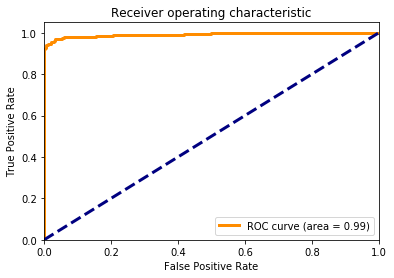

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

lsvm = SVC(kernel='linear', probability=True)

lsvm.fit(X_train_vect, y_train)

y_prediction_class = lsvm.predict(X_test_vect)

preds = lsvm.predict_proba(X_test_vect)[:,1]

cm = metrics.confusion_matrix(y_test, y_prediction_class)
print(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve of the SVM with linear kernel is very close to a perfect classifier with AUC of 0.99. This mean that SVM (with linear kernel) is a pretty good machine learning algorithm for SPAM detection.  
Also, SVM linear make few mistake, with only 1 false positive and 20 false negative.   
Compared to the Naive Bayes, there is less false positive, but more false negative.  
So even if the ROC curve is better than the Naive Bayes's ROC curve, it may be a worst classifier because we probably don't want many false negative.

Separate spam and non spam being a simple binary classification problem, a simple linear function seems to be enough.   Overall, with the Naive Bayes having very good results, we can guess that there is no need for complex systems to make good predictions.

### SVM with polynomial kernel

In [17]:
from sklearn.svm import SVC

psvm = SVC(kernel='poly')

score_poly = cross_val(psvm)

print("SVM with polynomial kernel : " + str(score_poly*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with polynomial kernel : 86.5942742418% accuracy


[[1207    0]
 [ 186    0]]


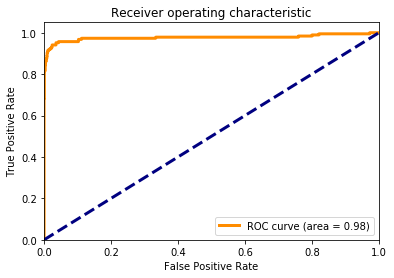

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

svm = SVC(kernel='poly', probability=True)

svm.fit(X_train_vect, y_train)

y_prediction_class = svm.predict(X_test_vect)

preds = svm.predict_proba(X_test_vect)[:,1]

cm = metrics.confusion_matrix(y_test, y_prediction_class)
print(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The SVM with polynomial kernel also have a good ROC curve. But we can see that the AUC score is lower than SVM with linear kernel. We know that SVM Polynomial have a 86% accuracy, which is much lower than the others classifier tested.  
The confusion matrix show us that in fact SVM with poly kernel allways predict the SMS to not be a spam.  
Since most SMD aren't spam, it has a good score. Still, it isn't a very interesting model.

### SVM with rbf kernel

In [18]:
rsvm = SVC(kernel='rbf')

score_rbf = cross_val(rsvm)

print("SVM with rbf kernel : " + str(score_rbf*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with rbf kernel : 86.5942742418% accuracy


### SVM with sigmoid kernel

In [19]:
ssvm = SVC(kernel='sigmoid')

score_sigmoid = cross_val(ssvm)

print("SVM with sigmoid kernel : " + str(score_sigmoid*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with sigmoid kernel : 86.5942742418% accuracy


All SVM with non-linear kernel all obtain the same 86.59%, which is a bit odd as we use different kernels. It probably show that the spam detection problem is simple enough that learning anything more complicated than a linear function doesn't work well.

Analysis of the confusion matrix show that all these model allways predict SMS to be a "legit" SMS, which make them not very interesting.

## Decision Tree

In [20]:
from sklearn import tree

t = tree.DecisionTreeClassifier()

score_tree = cross_val(t)

print("Decision Tree score : " + str(score_tree*100) + "% accuracy")

0.976702508961
0.976702508961
0.97486535009
0.97486535009
0.971274685817
0.971274685817
0.967684021544
0.964093357271
0.960502692998
0.973070017953
Decision Tree score : 97.110351795% accuracy


The decision tree work pretty well, doing 97% accuracy on average.

[[1197   10]
 [  23  163]]


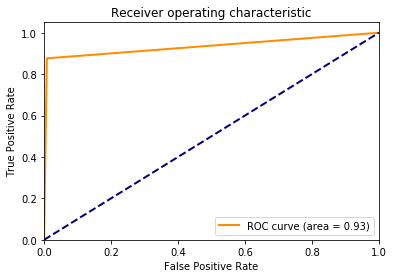

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

t = tree.DecisionTreeClassifier()

t.fit(X_train_vect, y_train)

y_prediction_class = t.predict(X_test_vect)

preds = t.predict_proba(X_test_vect)[:,1]

cm = metrics.confusion_matrix(y_test, y_prediction_class)
print(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

With the confusion matrix, we can see that decistion tree is pretty accurate. But it is worst than all the others classifier, except SVM with non-linear kernels.